# ScVelo workflow from AnnData object

## Import Modules

In [8]:
from platform import python_version
print(python_version())

3.8.13


In [9]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank@dev
    !pip install python-igraph

In [10]:
import scvelo as scv
import scanpy as sc

#Importing cellrank gave an error, specifically that dependency "Iterable" could not be imported. Turns out 
#Iterable was deprecated in collections, but can be manually imported from collections.abc, before importing cellrank
import collections.abc
collections.Iterable = collections.abc.Iterable
import cellrank as cr

import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

In [11]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

In [12]:
import pandas as pd

In [13]:
import anndata as ad

In [14]:
import matplotlib.pyplot as plt #loris

## Load meta data
Get this data from the R script: extract_meta_data.ipynb

In [15]:
sample_obs = pd.read_csv("./meta_data/GonadMeso_female_all/GonadMeso_female_all_v2_cellID_obs.csv")
umap_cord = pd.read_csv("./meta_data/GonadMeso_female_all/GonadMeso_female_all_v2_cell_embeddings.csv")
cell_clusters = pd.read_csv("./meta_data/GonadMeso_female_all/GonadMeso_female_all_v2_clusters.csv")
clusters_colors = pd.read_csv("./meta_data/GonadMeso_female_all/GonadMeso_female_all_v2_clusters_colors.csv")

## Load Loom files

In [16]:
sample = ad.read_loom("./Loom_files/GonadMeso/female.loom") 

In [17]:
sample.var_names_make_unique()

In [18]:
sample

AnnData object with n_obs × n_vars = 21049 × 36601
    obs: 'Clusters', '_X', '_Y'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

## Compare both files

In [19]:
sample.obs.head(2)

,Clusters,_X,_Y
CellID,,,
G1_AAAGATGCACATTCGA-1,6,-28.577442,19.646940
G1_AACTTTCAGGGTCGAT-1,3,2.973181,23.056271


In [20]:
sample_obs.head(2)

,x
0,G1_AAACCTGAGATGTGGC-1
1,G1_AAACCTGGTCAATGTC-1


In [21]:
umap_cord.head(2)

,Unnamed: 0,UMAP_1,UMAP_2
0,G1_AAACCTGAGATGTGGC-1,5.791826,7.670972
1,G1_AAACCTGGTCAATGTC-1,-1.221956,-6.536950


In [22]:
cell_clusters.head(2)

,cell_name,seurat_clusters
0,G1_AAACCTGAGATGTGGC-1,5
1,G1_AAACCTGGTCAATGTC-1,3


In [23]:
cell_clusters.shape

(21049, 2)

In [24]:
sample_obs.shape

(21049, 1)

#### Filtering > Filter/subset sample loom file to only include names in sample_obs file to be sure

In [25]:
#Use the numpy isin(element, test_element) function to subset sample_lm based on sample_obs' 
#"x" column
sample = sample[np.isin(sample.obs.index, sample_obs["x"])]

### Multiple-Sample Integration


In [26]:
#compare the length of sample_lm.obs to length of the set() of the same. set() creates a collection of unique elements
len(sample.obs.index), len(set(sample.obs.index))


(21049, 21049)

In [27]:
sample.obs.index.is_unique, sample.obs.index.is_unique, 

(True, True)

In [28]:
sample

View of AnnData object with n_obs × n_vars = 21049 × 36601
    obs: 'Clusters', '_X', '_Y'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

### Add UMAP

In [29]:
umap_cord

,Unnamed: 0,UMAP_1,UMAP_2
0,G1_AAACCTGAGATGTGGC-1,5.791826,7.670972
1,G1_AAACCTGGTCAATGTC-1,-1.221956,-6.536950
2,G1_AAACGGGGTCATGCCG-1,-1.731734,-5.027809
3,G1_AAAGATGCACAGGAGT-1,4.349940,5.223451
4,G1_AAAGATGCACATTCGA-1,4.848202,6.665842
...,...,...,...
21044,TTTGGTTTCTGGCTGG-1,-5.805374,-2.311154
21045,TTTGTTGAGCCTAACT-1,-7.060577,0.685946
21046,TTTGTTGAGCGATCGA-1,-6.768490,1.542647
21047,TTTGTTGAGTGCGACA-1,-7.292159,-0.384604


In [30]:
#Rename first column name from "Unnamed: 0" to "Cell ID"
umap_cord = umap_cord.rename(columns={'Unnamed: 0': 'Cell ID'})

In [32]:
#Make a panda dataframe from the observations in the loom file. You need to use .index for this. Rename first column from "0" to "Cell ID"
sample_index = pd.DataFrame(sample.obs.index)

#rename CellID to Cell ID
sample_index = sample_index.rename(columns = {'CellID': 'Cell ID'})

In [33]:
sample_index

,Cell ID
0,G1_AAAGATGCACATTCGA-1
1,G1_AACTTTCAGGGTCGAT-1
2,G1_AATCCAGAGAACAATC-1
3,G1_AATCCAGAGTCTTGCA-1
4,G1_AACACGTTCTACTTAC-1
...,...
21044,TTTGATCTCGACACTA-1
21045,TTTGGTTAGGCACCAA-1
21046,TTTGTTGAGTGCGACA-1
21047,TTTGATCGTCGAAGCA-1


In [34]:
#Order umap_cord according to sample_index order, by merging them with it based on Cell ID column
umap_ordered = sample_index.merge(umap_cord, on="Cell ID")

In [35]:
#Use iloc to select all rows (using the :,) and only the last 2 columns (using the 1:, 
#which means COLUMN 2 TO THE END, BECAUSE PYTHON STARTS COUNTING AT 0
umap_ordered = umap_ordered.iloc[:,1:]

In [36]:
#Now add umap_ordered values as a metadata variable "X_umap" into the sample AnnData object
#Are you adding 2 columns as 1 matrix then?
sample.obsm['X_umap'] = umap_ordered.values

In [37]:
sample

AnnData object with n_obs × n_vars = 21049 × 36601
    obs: 'Clusters', '_X', '_Y'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_umap'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

### Add clusters

In [38]:
#Rename first column from cell_clusters to Cell ID
cell_clusters = cell_clusters.rename(columns={'cell_name': 'Cell ID'})

In [39]:
#Order cell_clusters according to sample_index order, by merging them with it based on Cell ID column
cell_clusters = sample_index.merge(cell_clusters, on="Cell ID")

In [40]:
cell_clusters.head(2)

,Cell ID,seurat_clusters
0,G1_AAAGATGCACATTCGA-1,5
1,G1_AACTTTCAGGGTCGAT-1,3


In [41]:
#Use iloc again to basically remove first column
cell_clusters = cell_clusters.iloc[:,1:]

In [42]:
#Now add cell_clusters as a metadata variable "clusters" into the sample AnnData object
#make sure that it is added as a categorical variable!
#don't add it as obsm, but as obs, a new category of variable in the AnnData:
sample.obs['clusters'] = pd.Categorical(cell_clusters['seurat_clusters'])

### Add cluster colors

In [43]:
#Rename first column from cell_name to Cell ID
clusters_colors = clusters_colors.rename(columns={'cell_name': 'Cell ID'})

In [44]:
#Order cell_clusters according to sample_index order, by merging them with it based on Cell ID column
clusters_colors = sample_index.merge(clusters_colors, on="Cell ID")

In [45]:
clusters_colors.head(2)

,Cell ID,color
0,G1_AAAGATGCACATTCGA-1,#00BA38
1,G1_AACTTTCAGGGTCGAT-1,#A3A500


In [46]:
#Use iloc again to basically remove first column
clusters_colors = clusters_colors.iloc[:,1:]

In [47]:
#Now add cluster colors as a metadata variable "colors"" into the sample AnnData object
#don't add it as obsm or obs, but as uns, a new category of variable in the AnnData:
sample.uns['colors'] = clusters_colors

### Save AnnData object

In [48]:
sample.write_h5ad("/CEPH/users/jtaelman/GonadMeso_female_all.h5ad")

## RNA Velocity Scvelo

In [49]:
adata = sc.read_h5ad("/CEPH/users/jtaelman/GonadMeso_female_all.h5ad")

saving figure to file ./figures/GonadMeso/Female_all/scvelo_proportions.png


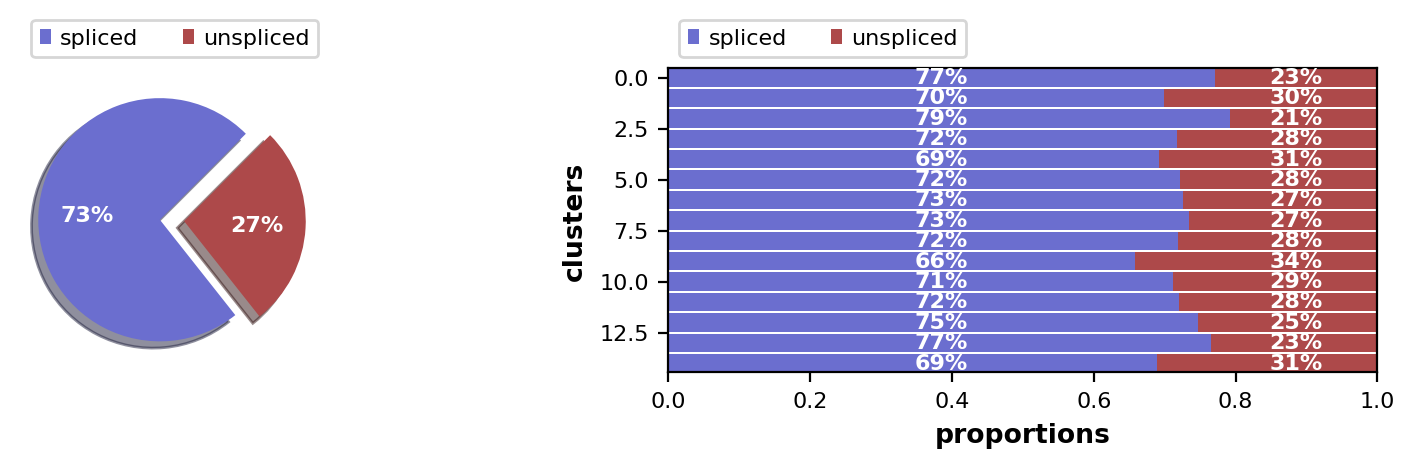

AnnData object with n_obs × n_vars = 21049 × 36601
    obs: 'Clusters', '_X', '_Y', 'clusters'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'colors'
    obsm: 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [50]:
scv.pl.proportions(adata, save="./figures/GonadMeso/Female_all/scvelo_proportions.png")
adata

In [51]:
#Scvelo preparation

scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 22552 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing moments based on connectivities
    finished (0:00:04) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [52]:
#Run ScVelo
scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata, n_jobs=40)

computing velocities
    finished (0:00:39) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 40/70 cores)


  0%|          | 0/21049 [00:00<?, ?cells/s]

    finished (0:01:23) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:23) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/GonadMeso/Female_all/Default_scvelo_stochastic_grid.png


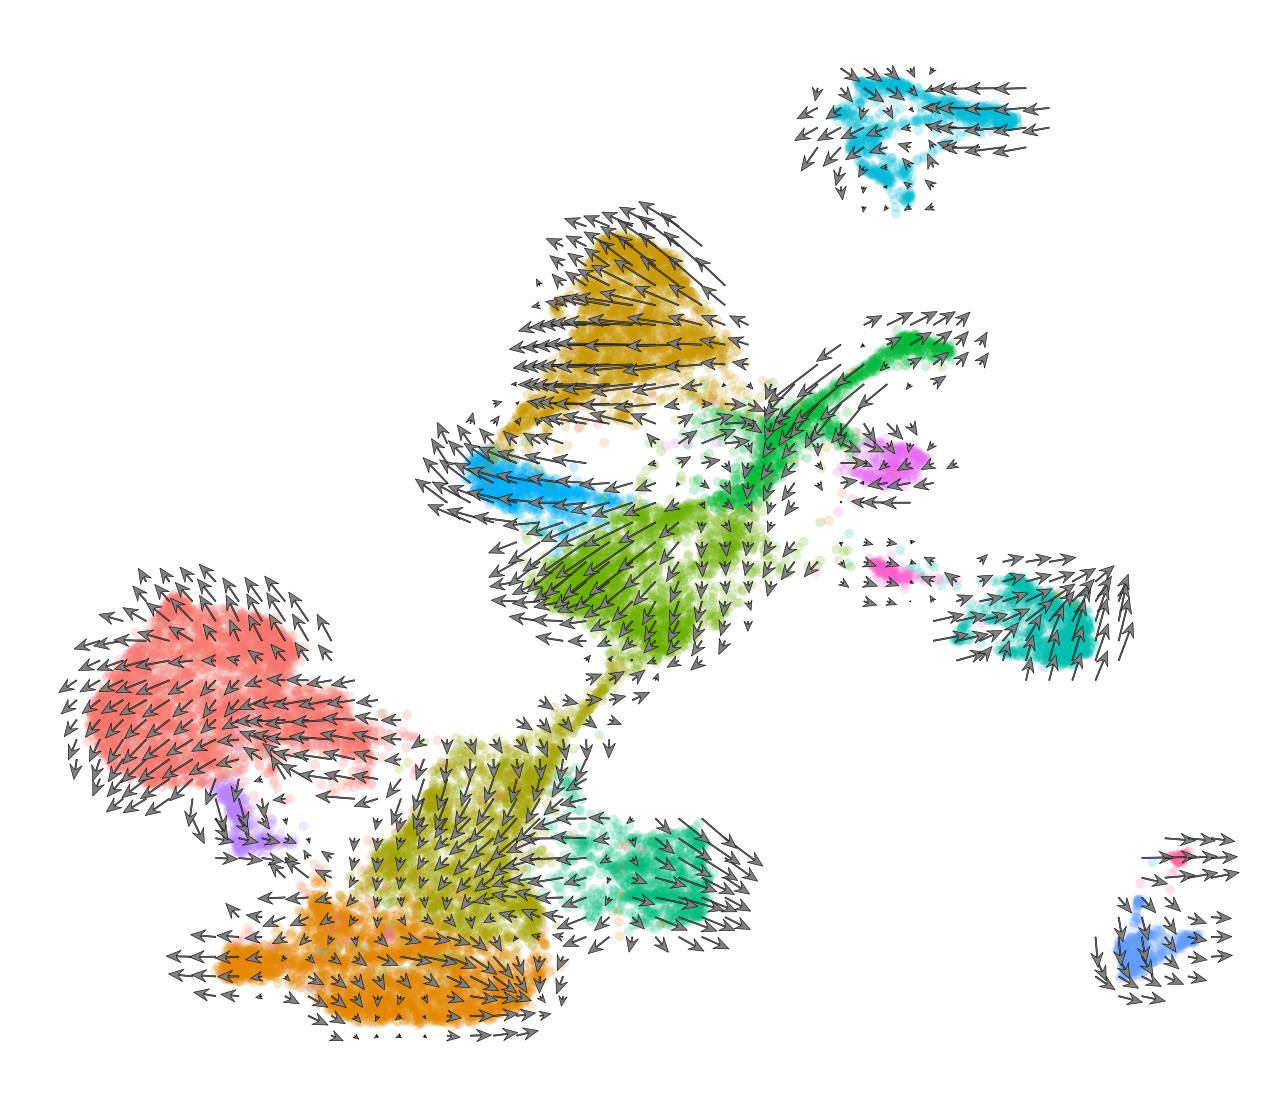

saving figure to file ./figures/GonadMeso/Female_all/Default_scvelo_stochastic_grid.svg


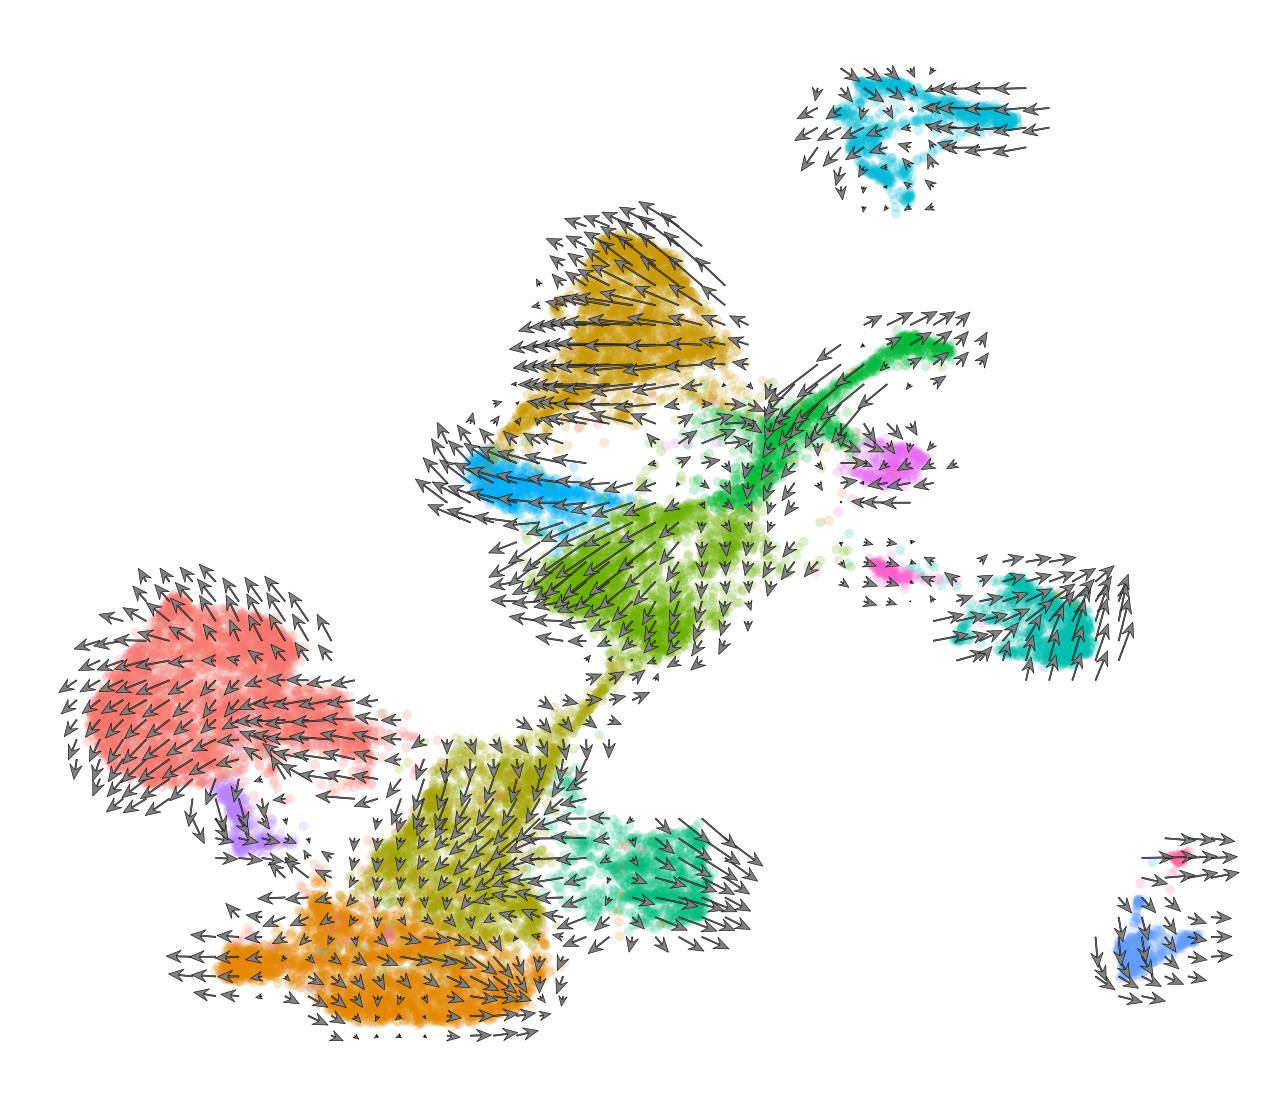

In [53]:
#Default scvelo stochastic plots
scv.pl.velocity_embedding_grid(adata,arrow_length=3, legend_loc = 'on data', arrow_size=2,basis="umap", color=adata.uns['colors'], legend_fontsize=12, title="", 
    smooth=0.8, min_mass=4, save="./figures/GonadMeso/Female_all/Default_scvelo_stochastic_grid.png",
    figsize=(8, 7),colorbar=False
)
scv.pl.velocity_embedding_grid(adata,arrow_length=3, legend_loc = 'on data', arrow_size=2,basis="umap", color=adata.uns['colors'], legend_fontsize=12, title="", 
    smooth=0.8, min_mass=4, save="./figures/GonadMeso/Female_all/Default_scvelo_stochastic_grid.svg",
    figsize=(8, 7),colorbar=False
)


### END